In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
from scipy import integrate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)

In [4]:
%matplotlib widget

#### Functions

In [5]:
## From David Wyrick, 05.2025 ##
def get_burst_events(spk_times, isi_interval=0.005, min_spikes=2, quiescence=0.1):
    isi_min = 1.5/1000 #ms
    #Get ISIs
    isi = np.diff(spk_times)
 
    #Get where bursts occur (e.g. ISI < 4ms)
    burst_indices_all = np.where((isi <= isi_interval) & (isi >= isi_min))[0] #& (isi >= isi_min)
 
    if len(burst_indices_all) == 0:
        return [np.nan], [np.nan], [np.nan], [np.nan], [np.nan], [np.nan], [np.nan]
 
    nISI_viol = np.sum(isi < isi_min)
    nISI_burst = np.sum(isi <= isi_interval)
    isi_viol_burst_frac = nISI_viol/nISI_burst
 
    # if nISI_viol > 0:
    #     print(f'ISI violation: {nISI_viol} spikes out of {nISI_burst} ISIs detected: {nISI_viol/nISI_burst:.3f} fraction')
 
    #Subselect indices that begin each burst & get number of spikes per burst
    tmp = np.diff(np.concatenate(([-1],burst_indices_all)))
    indy = np.where(tmp > 1)[0]
    burst_indices_s = burst_indices_all[indy]
    burst_sizes = np.diff(np.concatenate((indy,[len(tmp)]))) + 1
    burst_indices_e = burst_indices_s + burst_sizes - 1
 
    #Calculate mean frequency for each burst
    burst_freqs = np.array([1/np.mean(isi[i:j]) for i,j in zip(burst_indices_s,burst_indices_e)])
 
    #Calculate number of bursts
    num_bursts = [len(burst_sizes)]
 
    #Apply minimum number of spikes criterion
    indy = np.where(burst_sizes >= min_spikes)[0]
    burst_indices_s = burst_indices_s[indy]
    burst_sizes = burst_sizes[indy]
    burst_freqs = burst_freqs[indy]
    num_bursts.append(len(burst_sizes))
    
    #Apply queiscence criterion if necessary
    indy = np.where(spk_times[burst_indices_s] - spk_times[burst_indices_s-1] > quiescence)[0]
    burst_indices_s = burst_indices_s[indy]
    burst_sizes = burst_sizes[indy]
    burst_freqs = burst_freqs[indy]
    num_bursts.append(len(burst_sizes))
 
    #Get burst times
    burst_spk_times = spk_times[burst_indices_s]
 
    #Calculate burst lengths
    burst_lengths = np.array([spk_times[iS + burst_sizes[ii] - 1] - spk_times[iS] for ii, iS in enumerate(burst_indices_s)])
 
    return burst_spk_times, burst_indices_s, burst_sizes, burst_freqs, burst_lengths, num_bursts, isi_viol_burst_frac

In [6]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [7]:
def get_stim_event_times(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].onset.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].onset.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].onset.values

In [8]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

## Load subject

In [9]:
recfolder = r'E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_estim_2022-12-22_10-36-08\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [10]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\burst_analyses'

## Test with one subject

In [11]:
evoked_data_folder = os.path.join(exp.data_folder, 'evoked_data')

## Load unit info ##
fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(evoked_data_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_spikes = pickle.load(unit_file)
else:
    print('  {} not found. Not analyzing this subject\n.'.format(fn_units_stats))

In [14]:
regdf = unit_info[unit_info['parent_region'] == 'SM-TH']
regdf.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B1,probeB,0,3680,0.398325,PO,269,162,173,SM-TH
1,B12,probeB,0,3680,0.398325,PO,269,162,173,SM-TH
2,B3,probeB,1,3680,0.384590,PO,269,162,173,SM-TH
3,B4,probeB,1,3680,0.494472,PO,269,162,173,SM-TH
4,B5,probeB,1,3680,0.343384,PO,269,162,173,SM-TH


In [15]:
regdf[40:60]

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
40,B66,probeB,21,3480,0.453266,PO,269,153,172,SM-TH
41,B738,probeB,21,3480,0.453266,PO,269,153,172,SM-TH
42,B654,probeB,21,3480,0.508208,PO,269,153,172,SM-TH
43,B67,probeB,22,3460,0.467002,PO,269,152,172,SM-TH
44,B71,probeB,23,3460,0.439531,PO,269,152,172,SM-TH
45,B72,probeB,24,3440,0.439531,PO,269,151,172,SM-TH
46,B73,probeB,25,3440,0.480737,PO,269,151,172,SM-TH
47,B74,probeB,25,3440,0.439531,PO,269,151,172,SM-TH
48,B75,probeB,25,3440,0.439531,PO,269,151,172,SM-TH
49,B95,probeB,25,3440,0.508208,PO,269,151,172,SM-TH


In [12]:
type(all_unit_spikes['F900'])

dict

Plot ISIs

12523


Text(0, 0.5, 'Post ISI')

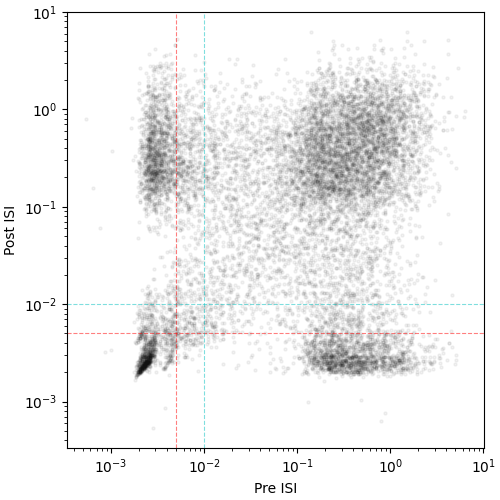

In [16]:
uspikes = all_unit_spikes['B75']['spikes']
print(len(uspikes))

preISIs = np.diff(uspikes)[:-1]
postISIs = np.diff(uspikes)[1:]

fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
ax.scatter(preISIs, postISIs, color='k', s=5, alpha=0.05)
ax.axvline(0.005, color='r', linestyle='dashed', linewidth=0.8, alpha=0.5)
ax.axhline(0.005, color='r', linestyle='dashed', linewidth=0.8, alpha=0.5)
ax.axvline(0.01, color='c', linestyle='dashed', linewidth=0.8, alpha=0.5)
ax.axhline(0.01, color='c', linestyle='dashed', linewidth=0.8, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Pre ISI')
ax.set_ylabel('Post ISI')

### Method 1: loop through all spikes, test pre- and post- ISI

Test with one spike train

In [17]:
s1 = time.time()
alluspikes = all_unit_spikes['B75']['spikes']

burst_starts_m1 = []
burst_all_m1 = []
IN_BURST = False
for spi in range(1, len(alluspikes)-1):
    preISI = alluspikes[spi] - alluspikes[spi-1]
    postISI = alluspikes[spi+1] - alluspikes[spi]
    if (preISI > 0.1) & (postISI < 0.004):
        burst_starts_m1.append(spi)
        burst_all_m1.append(spi)
        IN_BURST = True
    elif IN_BURST & (preISI < 0.004):
        burst_all_m1.append(spi)
    else:
        IN_BURST = False
# print(len(burst_starts_m1))
e1 = time.time()
print((e1-s1))

0.03127026557922363


In [42]:
print(len(burst_starts_m1))

170


### Method 2: find starts using arrays, loop through starts

Test with one spike train

In [18]:
s2 = time.time()
## Burst-finding method 2: using arrays and a loop ##
alluspikes = all_unit_spikes['B75']['spikes']

preISIs = np.diff(alluspikes)[:-1]
postISIs = np.diff(alluspikes)[1:]

bs_inds = np.nonzero((preISIs > 0.1) * (postISIs < 0.004))[0]
burst_starts_m2 = bs_inds + 1 # +1 corrects for the actual spike ind

## Loop through burst starts to find spikes that belong to the burst
allbinds = bs_inds.tolist()
for st_ind in bs_inds:
    spkind = st_ind+1
    while preISIs[spkind] < 0.004:
        allbinds.append(spkind)
        spkind += 1
burst_all_m2 = np.sort(allbinds) + 1 # +1 corrects for the actual spike ind
e2 = time.time()
print((e2-s2))

0.004996061325073242


In [24]:
print(len(burst_all_m2))

3388


### Test David's burst finding

In [22]:
sd = time.time()

alluspikes = all_unit_spikes['B75']['spikes']
Dburst_times, Dburst_inds, Dburst_counts, Dburst_freqs, Dburst_lengths, Dnum_bursts, Disi_viol_burst_frac = get_burst_events(alluspikes, isi_interval=0.004, min_spikes=2, quiescence=0.1)

ed = time.time()
print((ed-sd))

0.03801727294921875


In [26]:
print(len(Dburst_times))
print(len(Dburst_lengths))

1356
1356


In [28]:
print(Dburst_times[:10])
print(Dburst_counts[:10])
print(Dnum_bursts[:10])

[ 34.78120795  34.96827398  45.41340466  47.13779872  55.00297163
  57.23476394  68.90885707  85.4861333   99.35605671 106.41690666]
[2 3 2 2 3 2 2 3 2 4]
[1474, 1474, 1356]


In [31]:
print(Dburst_freqs[:10])
print(Disi_viol_burst_frac)

[303.03134684 405.40680185 329.67146525 250.00086114 419.58186486
 306.12350344 344.82877399 346.8220039  280.37449574 400.00094726]
0.0027688047992616522


### Method 3: find bursts using ISI threshold only (for bursting in ctx, too)

Test with one spike train

In [32]:
ISI_threshold = 0.01 # ISI less than or equal to 15 ms
spike_count_thresh = 3 # at least this number of spikes to be considered burst

s3 = time.time()
## Burst-finding method 3: using an ISI threshold (pre spike ISI) only ##
alluspikes = all_unit_spikes['B75']['spikes']
preISIs = np.insert(np.diff(alluspikes), 0, 1.0)

burst_starts = []
burst_list = []
burst_counts = []
spkind = 0
while spkind < len(alluspikes):
    tempevent = [alluspikes[spkind]]
    spkind += 1
    while (spkind < len(alluspikes)) and (preISIs[spkind] < ISI_threshold):
        tempevent.append(alluspikes[spkind])
        spkind += 1
    if len(tempevent) >= spike_count_thresh:
        burst_starts.append(tempevent[0])
        burst_list.append(tempevent)
        burst_counts.append(len(tempevent))
    del tempevent
    
e3 = time.time()
print((e3-s3))

0.03716254234313965


In [20]:
print(len(alluspikes))
print(len(preISIs))

12523
12523


In [21]:
preISIs[:10]

array([1.        , 0.59703128, 0.16163278, 0.3586321 , 0.49683162,
       0.64896443, 0.81196387, 1.63132771, 0.00329999, 0.18376603])

In [82]:
print(len(burst_starts))
print(len(burst_list))

1257
1257


In [83]:
burst_list[0:5]

[[107.70929002672875, 107.71269001940875, 107.71769000864404],
 [107.73118997957931,
  107.7368233007844,
  107.74178995675811,
  107.74712327860908,
  107.75232326741377,
  107.75755658948005,
  107.76288991133102,
  107.77038989518394],
 [107.82905643554463,
  107.8369230852748,
  107.84252307321833,
  107.8491230590089,
  107.8548563799987],
 [107.86755635265632,
  107.87615633414102,
  107.88502298171827,
  107.89052296987707,
  107.89825628656098,
  107.90775626610802,
  107.91482291756056],
 [107.95945615480088, 107.9667561390844, 107.97242279355105]]

In [84]:
burst_counts[:5]

[3, 8, 5, 7, 3]

In [85]:
burst_starts[:5]

[107.70929002672875,
 107.73118997957931,
 107.82905643554463,
 107.86755635265632,
 107.95945615480088]

Compare results from both methods

In [22]:
print(burst_starts_m1[0:15])
print(burst_starts_m2[0:15])

[582, 944, 959, 976, 995, 997, 1006, 1023, 1063, 1065, 1082, 1157, 1234, 1252, 2085]
[ 582  944  959  976  995  997 1006 1023 1063 1065 1082 1157 1234 1252
 2085]


In [23]:
print(len(burst_all_m1))
print(len(burst_all_m2))

3015
3015


In [24]:
print(burst_all_m1[0:20])
print(burst_all_m2[0:20])

[582, 583, 944, 945, 959, 960, 976, 977, 995, 996, 997, 998, 999, 1000, 1006, 1007, 1008, 1023, 1024, 1063]
[ 582  583  944  945  959  960  976  977  995  996  997  998  999 1000
 1006 1007 1008 1023 1024 1063]


### Method RT bursts: find bursts with ISI < 4 ms (4-8 spikes)

Test with one spike train

In [54]:
s2 = time.time()
## Burst-finding method 2: using arrays and a loop ##
alluspikes = all_unit_spikes['C28']['spikes']

preISIs = np.diff(alluspikes)[:-1]
postISIs = np.diff(alluspikes)[1:]

bs_inds = np.nonzero((preISIs > 0.004) * (postISIs < 0.004))[0]
RT_burst_starts = bs_inds + 1 # +1 corrects for the actual spike ind

all_bursts = []
allbinds = bs_inds.tolist()
for st_ind in bs_inds:
    spkind = st_ind+1
    while preISIs[spkind] < 0.004:
        allbinds.append(spkind)
        spkind += 1


IN_BURST = True
for st_ind in bs_inds:
    spcount = 1
    spkind = st_ind+1
    while (preISIs[spkind] < 0.004) and (postISIs[spkind] < 0.004):
        spcount = 1
        spkind += 1


# ## Loop through burst starts to find spikes that belong to the burst
# allbinds = bs_inds.tolist()
# for st_ind in bs_inds:
#     spkind = st_ind+1
#     while preISIs[spkind] < 0.004:
#         allbinds.append(spkind)
#         spkind += 1
# burst_all_m2 = np.sort(allbinds) + 1 # +1 corrects for the actual spike ind
# e2 = time.time()
# print((e2-s2))

In [56]:
np.diff(alluspikes[0:10])

array([0.01469997, 0.11766645, 0.01083331, 0.00283333, 0.00366666,
       0.01173331, 0.01046665, 0.01056665, 0.00446666])

In [55]:
print(RT_burst_starts)

[    3   295   403   470   480   503   622   647   686   711   733   765
   777   821   849   874   916   920   948   976   989  1013  1173  1227
  1263  1314  1319  1389  1506  1562  1570  1677  1827  1974  1977  2001
  2009  2011  2051  2100  2102  2104  2106  2126  2141  2210  2269  2308
  2318  2376  2459  2474  2477  2521  2532  2534  2617  2702  2760  2807
  2881  2912  2928  2957  2962  3005  3036  3087  3193  3195  3337  3358
  3408  3452  3480  3570  3585  3658  3660  3671  3681  3697  3710  3764
  3802  3836  3879  4082  4174  4176  4189  4267  4271  4379  4401  4462
  4502  4530  4546  4607  4622  4625  4733  4747  4863  4866  4907  4939
  4953  5015  5032  5052  5065  5089  5107  5126  5156  5174  5181  5212
  5239  5250  5305  5361  5374  5382  5394  5408  5425  5430  5447  5631
  5682  5692  5699  5715  5737  5746  5834  5842  5982  5997  6130  6132
  6157  6257  6305  6333  6385  6400  6418  6420  6423  6427  6485  6535
  6566  6579  6589  6596  6608  6622  6685  6702  6

### Compare timing of both methods for multiple neurons

Method 1: loop through all spikes

In [25]:
s1 = time.time()

reg_units = regdf['unit_id'].values
for uid in reg_units:
    alluspikes = all_unit_spikes[uid]

    burst_starts_m1 = []
    burst_all_m1 = []
    IN_BURST = False
    for spi in range(1, len(alluspikes)-1):
        preISI = alluspikes[spi] - alluspikes[spi-1]
        postISI = alluspikes[spi+1] - alluspikes[spi]
        if (preISI > 0.1) & (postISI < 0.004):
            burst_starts_m1.append(spi)
            burst_all_m1.append(spi)
            IN_BURST = True
        elif IN_BURST & (preISI < 0.004):
            burst_all_m1.append(spi)
        else:
            IN_BURST = False
    
e1 = time.time()
print('Method 1, all units, search time: {:.2f} s'.format(e1-s1))

Method 1, all units, search time: 14.13 s


Method 2: use arrays first

In [26]:
s2 = time.time()

reg_units = regdf['unit_id'].values
for uid in reg_units:
    alluspikes = all_unit_spikes[uid]
    preISIs = np.diff(alluspikes)[:-1]
    postISIs = np.diff(alluspikes)[1:]

    bs_inds = np.nonzero((preISIs > 0.1) * (postISIs < 0.004))[0]
    burst_starts_m2 = bs_inds + 1 # +1 corrects for the actual spike ind

    ## Loop through burst starts to find spikes that belong to the burst
    allbinds = bs_inds.tolist()
    for st_ind in bs_inds:
        spkind = st_ind+1
        while (spkind < len(preISIs)) and (preISIs[spkind] < 0.004):
            allbinds.append(spkind)
            spkind += 1
    burst_all_m2 = np.sort(allbinds) + 1 # +1 corrects for the actual spike ind

e2 = time.time()
print('Method 2, all units, search time: {:.2f} s'.format(e2-s2))

Method 2, all units, search time: 0.24 s


Compare results from both methods

In [27]:
print(len(burst_starts_m1))
print(len(burst_starts_m2))

470
470


In [28]:
print(burst_starts_m1[0:15])
print(burst_starts_m2[0:15])

[2075, 5226, 10217, 12848, 14794, 15327, 15486, 16158, 17323, 17327, 17365, 17937, 18156, 18605, 20098]
[ 2075  5226 10217 12848 14794 15327 15486 16158 17323 17327 17365 17937
 18156 18605 20098]


In [29]:
print(len(burst_all_m1))
print(len(burst_all_m2))

1048
1048


### Info to save?

This saves the times of the first spike of each burst ['start_times'], the times of all spikes in a burst ['all_times'], the number of spikes belonging to each burst ['burst_spike_counts'], and a list of the spike times that belong to each burst ['burst_spike_times'].
<br>**But probably the most relevant are the ['start_times'] and ['burst_spike_counts'].**

In [43]:
start = time.time()

reg_units = regdf['unit_id'].values
burst_info = {}

for uid in reg_units:
    alluspikes = all_unit_spikes[uid]
    preISIs = np.diff(alluspikes)[:-1]
    postISIs = np.diff(alluspikes)[1:]

    bs_inds = np.nonzero((preISIs > 0.1) * (postISIs < 0.004))[0]
    if len(bs_inds) == 0:
        continue
    burst_starts_m2 = bs_inds + 1 # +1 corrects for the actual spike ind

    ## Loop through burst starts to find spikes that belong to the burst
    allbinds = bs_inds.tolist()
    burst_counts = []
    all_burst_times = []
    for st_ind in bs_inds:
        spkind = st_ind+1
        ind_burst_times = [alluspikes[spkind]]
        bcount = 1
        while (spkind < len(preISIs)) and (preISIs[spkind] < 0.004):
            allbinds.append(spkind)
            spkind += 1
            ind_burst_times.append(alluspikes[spkind])
            bcount += 1
        burst_counts.append(bcount)
        all_burst_times.append(np.array(ind_burst_times))
    burst_all_m2 = np.sort(allbinds) + 1 # +1 corrects for the actual spike ind
    
    ## store burst info ##
    burst_info[uid] = {}
    burst_info[uid]['start_times'] = alluspikes[burst_starts_m2]
    burst_info[uid]['all_times'] = alluspikes[burst_all_m2]
    burst_info[uid]['burst_spike_counts'] = np.array(burst_counts)
    burst_info[uid]['burst_spike_times'] = all_burst_times
    
end = time.time()
print('Method 2, all units, search time: {:.2f} s'.format(end-start))

Method 2, all units, search time: 0.51 s


In [44]:
len(burst_info['B0']['burst_spike_counts'])

1343

In [45]:
len(burst_info['B0']['burst_spike_times'])

1343

In [51]:
test_ind = 5
print(burst_info['B0']['start_times'][test_ind])
print(burst_info['B0']['burst_spike_counts'][test_ind])
print(burst_info['B0']['burst_spike_times'][test_ind])

144.16321360599198
4
[144.16321361 144.16538027 144.16738026 144.17134692]


### Make it into a function

In [ ]:
## Developed in NPX_find_bursts_testing.ipynb, this version is faster and only returns start times and spike counts ##
def find_bursts(unit_ids, all_spikes_dict):
    burst_info = {}
    for uid in unit_ids:
        alluspikes = all_spikes_dict[uid]
        preISIs = np.diff(alluspikes)[:-1]
        postISIs = np.diff(alluspikes)[1:]
        ## Find starts ##
        bs_inds = np.nonzero((preISIs > 0.1) * (postISIs < 0.004))[0]
        if len(bs_inds) == 0:
            continue
        burst_starts = bs_inds + 1 # +1 corrects for the actual spike ind
        ## Loop through burst starts to find spikes that belong to the burst
        burst_counts = []
        for st_ind in bs_inds:
            spkind = st_ind+1
            bcount = 1
            while (spkind < len(preISIs)) and (preISIs[spkind] < 0.004):
                spkind += 1
                bcount += 1
            burst_counts.append(bcount)
        ## Store burst info ##
        burst_info[uid] = {}
        burst_info[uid]['start_times'] = alluspikes[burst_starts]
        burst_info[uid]['burst_spike_counts'] = np.array(burst_counts)
    return burst_info